In [23]:
import polars as pl
import numpy as np
import random
import time
import warnings
import munkres
import sys
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import pandas as pd

warnings.filterwarnings(
    "ignore",
    category=pl.exceptions.MapWithoutReturnDtypeWarning
)
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [41]:
POSITIONS = ["og", "oo", "cg", "co"]
SPEAK_SCALE = 1 # scale of gumbel dist, should be 1

# motion bias params
HALF_MEAN = 0.08 # positive, so favours opening half
HALF_STDEV = 0.1
BENCH_MEAN = -0.12 # negative, so favours opp bench
BENCH_STDEV = 0.15
DIAG_MEAN = -0.04 # negative, so favours short diag
DIAG_STDEV = 0.08

OUTROUND_DRAW = pl.read_csv("outround_draw.csv")

In [3]:
def worlds_gen(num_teams, skill_sd):
    """
    This comes up with the start of a wudc

    Parameters:
    num_teams (int): how many teams (must be divisible by 4)
    skill_sd (float): stdev of team skill

    Returns:
    wudc (DataFrame): 
        column "name" is for random team names
        column "skill" is their skill
            (in A v B, first team wins with prob logit(A-B))
        column "points" is how many points they have; start at 0
        other positions are counts for how many times they ahve done that position
    """
    team_names = [
        "".join([
            random.choice("ABCDEFGHIJKLMNOPQRSTUVWXYZ")
            for a in range(16)
        ])
        for b in range(num_teams)
    ]
    wudc = pl.DataFrame({
        "name": team_names,
        "skill": np.random.normal(0, skill_sd, num_teams),
        "points": 0.0,
        "og": 0,
        "oo": 0,
        "cg": 0,
        "co": 0
    })
    return wudc

In [4]:
def get_cost_col(wudc, position, round_num):
    """
    HELPER METHOD FOR get_full_cost_matrix()
    takes in: 
        wudc (dataframe)
        position (str, one of "og", "oo", "cg", "co")
        round_num (int)
    returns a column, which is cost of each teams being given that position
    """
    exponent = 4
    updated = wudc.select(POSITIONS).with_columns(
        (pl.col(position) + 1).alias(position)
    ) / round_num
    updated = (
        updated * pl.DataFrame(np.log2(updated), schema=POSITIONS)
    ).fill_nan(0) * -1
    cost = ((2 - updated.sum_horizontal()) * round_num) ** exponent
    return cost

In [5]:
def get_full_cost_matrix(wudc, round_num):
    """
    HELPER METHOD FOR generate_draw()
    takes in:
        wudc (dataframe)
        round_num (int)
    returns dataframe with num_teams columns
        one per (room, position) slot
        value is cost of that row's team getting that column's slot
    """
    four_col = pl.DataFrame(dict(zip(
        POSITIONS, 
        [get_cost_col(wudc, p, round_num) for p in POSITIONS]
    )))
    copies = [
        four_col.clone().rename(lambda x: f"{i + 1}_" + x)
        for i in range(int(wudc.height / 4))
    ]
    conjoined = pl.concat(copies, how="horizontal")
    return conjoined

In [6]:
def do_pullups(points):
    """
    HELPER METHOD FOR add_disalloweds_wudc
    takes in:
        points (list of ints), which is how many points each team is on
    returns:
        rooms TODO: fill in with what this actually is
    Just about copied from the tabbycat documentation
    """
    counts = Counter(points)
    rooms = []
    allowed = set()
    nteams = 0
    level = None
    pullups_needed = 0
    for p in sorted(counts.keys(), reverse=True):
        if pullups_needed < counts[p]: # complete the bracket
            if pullups_needed:
                allowed.add(p)
                counts[p] -= pullups_needed
                nteams += pullups_needed
            assert nteams % 4 == 0
            rooms += [(level, allowed)] * (nteams // 4)
            nteams = 0
            allowed = set()
            level = None

        # add this entire bracket to the bracket
        if counts[p] > 0:
            allowed.add(p)
            if level is None:
                level = p
        nteams += counts[p]
        pullups_needed = (-nteams) % 4

    assert nteams % 4 == 0
    rooms += [(level, allowed)] * (nteams // 4)

    return rooms

In [7]:
def add_disalloweds_wudc(wudc, cost_matrix):
    """
    HELPER METHOD FOR generate_draw()
    takes in:
        cost matrix (dataframe): num_teams x num_teams grid of penalties for each position
    returns:
        cost_matrix (dataframe): same thing, but with impossible positions blocked out
    i.e., takes in dataframe that just penalises position
        and adds to that penalties for being outside bracket
    """
    points = ()
    rooms = do_pullups(wudc.get_column("points").to_list())
    low_scores = [min(rooms[i][1]) for i in range(len(rooms))]
    high_scores = [max(rooms[i][1]) for i in range(len(rooms))]
    penalties = wudc.select([
        # This looks pretty nasty
        # Really it just identifies cells that aren't allowed
        #     (team's points too low or too high for given room)
        # And fills them in with system max value
        (
            (
                (pl.col("points") < low_scores[i])
                + (pl.col("points") > high_scores[i])
            ) * sys.maxsize
        ).alias(f"{i}_{p}")
        for i in range(len(rooms))
        for p in POSITIONS
    ])
    return cost_matrix + penalties

In [8]:
def generate_bias():
    """
    Returns bias based on empirical estimates
    Does this by decomposing into (half, bench, diagonal) orthogonal components
    Then combining
    Returns a dictionary of (int, float)
        key is team encoded as int (0 og, 1 oo, ...)
        value is amount the motion favours their position
    """
    half_bias = np.random.normal(HALF_MEAN, HALF_STDEV)
    bench_bias = np.random.normal(BENCH_MEAN, BENCH_STDEV)
    diag_bias = np.random.normal(DIAG_MEAN, DIAG_STDEV)
    return {
        0: half_bias + bench_bias + diag_bias,
        1: half_bias - bench_bias - diag_bias,
        2: -half_bias + bench_bias - diag_bias,
        3: -half_bias - bench_bias + diag_bias
    }

In [9]:
def generate_draw(wudc, round_num):
    """
    Takes in a wudc dataframe
    returns it with extra columns:
        r{round_num}_pos: 0, 1, 2, 3 if in og, oo, cg, co
        r{round_num}_room: top room is 1, bottom room is ~75
        r{round_num}_bias: how much motion favours that position
    """
    # Step 1: Generate the draw
    wudc = wudc.sort(
        # Sort by points, shuffle within each bracket for draw algo to work
        pl.col("points") + np.random.normal(0, 0.0001, wudc.height),
        descending=True
    )
    cost_matrix = get_full_cost_matrix(wudc, round_num)
    cost_matrix = add_disalloweds_wudc(wudc, cost_matrix)
    indices = munkres.Munkres().compute(cost_matrix.to_numpy())
    destinations = pl.Series([index[1] for index in indices])
    room_nums = np.floor(destinations / 4) + 1

    # Step 2: Put all that relevant info into dataframe
    wudc = wudc.with_columns(
        pl.Series(name=f"r{round_num}_pos", values=destinations % 4),
        pl.Series(name=f"r{round_num}_room", values=destinations // 4 + 1)
    )
    # And update position counts
    updates = (destinations % 4).to_dummies().rename(lambda x: POSITIONS[int(x[1])])
    wudc = wudc.with_columns([
        (pl.col(name) + updates[name]).alias(name)
        for name in updates.columns
    ])

    # Step 3: Add in motion bias
    bias = generate_bias()
    wudc = wudc.with_columns(
        pl.col(f"r{round_num}_pos").replace_strict(bias).alias(f"r{round_num}_bias")
    )
    return wudc

In [10]:
def get_results(wudc, round_num):
    """
    Takes in a wudc dataframe, with draw info added
    Adds two columns:
        r{round_num}_speaks: their performance that round
        r{round_num}_result: number of points they got
    And updates "points" column to account for new results
    """
    return wudc.with_columns(
        # 1. Get performance for each round
        pl.Series(
            name=f"r{round_num}_speaks", 
            values=np.random.gumbel(
                wudc.get_column("skill") + wudc.get_column(f"r{round_num}_bias"), 
                SPEAK_SCALE
            )
        )
    ).sort(
        # 2. i.e., sort by performance within each room
        pl.col(f"r{round_num}_room") * 10**8 * -1 + pl.col(f"r{round_num}_speaks"),
        descending=True
    ).with_columns(
        # 3. Fill in results according to performance
        pl.Series(
            name=f"r{round_num}_result",
            values=[3, 2, 1, 0] * (wudc.height // 4)
        )
    ).with_columns(
        # 4. Update total results
        (pl.col("points") + pl.col(f"r{round_num}_result")).alias("points")
    )

In [11]:
def run_round(wudc, round_num):
    wudc = generate_draw(wudc, round_num)
    wudc = get_results(wudc, round_num)
    return wudc

In [17]:
def estimate_skills(wudc):
    positives = []
    negatives = []
    targets = []
    for round_num in range(1, 10):
        name_grid = wudc.pivot(on=f"r{round_num}_pos", index=f"r{round_num}_room", values="name")
        speak_grid = wudc.pivot(on=f"r{round_num}_pos", index=f"r{round_num}_room", values=f"r{round_num}_speaks")
        
        combs = [("0", "1"), ("0", "2"), ("0", "3"), ("1", "2"), ("1", "3"), ("2", "3")]
        for pos_a, pos_b in combs:
            a_df = name_grid[pos_a].alias("").to_dummies(separator="").with_columns(
                pl.lit(1).alias(f"{round_num}_{pos_a}")
            )
            positives.append(a_df)
            b_df = name_grid[pos_b].alias("").to_dummies(separator="").with_columns(
                pl.lit(1).alias(f"{round_num}_{pos_b}")
            )
            negatives.append(b_df)
            target = (speak_grid[pos_a] > speak_grid[pos_b]).alias("first_wins")
            targets.append(target)
    positives = pl.concat(positives, how="diagonal").fill_null(value=0)
    negatives = pl.concat(negatives, how="diagonal").fill_null(value=0)
    targets = pl.concat(targets)
    
    all_cols = sorted(set(positives.columns) | set(negatives.columns))
    
    result = positives.select([
        pl.col(c) if c in positives.columns else pl.lit(0).alias(c) 
        for c in all_cols
    ]).cast(pl.Int64) - negatives.select([
        pl.col(c) if c in negatives.columns else pl.lit(0).alias(c)
        for c in all_cols
    ]).cast(pl.Int64)
    
    model = LogisticRegression(C=SPEAK_SCALE, fit_intercept=False)
    model.fit(result, targets)
    coef_dict = dict(zip(result.columns, model.coef_[0]))
    wudc = wudc.with_columns(
        pl.col("name").replace_strict(coef_dict).alias("est_skill")
    )
    return wudc

In [13]:
def run_outround(wudc, round_name, round_rooms):
    bias = generate_bias()
    wudc = wudc.sort(
        # Sort into rooms
        pl.col("live").cast(pl.Int64) * 1e6 + pl.col(round_name) + np.random.normal(0, 0.000001, wudc.height), 
        descending=True, 
        nulls_last=True
    ).with_columns(
        # Assign positions
        pl.Series(
            name=f"{round_name}_position", 
            values=[0, 1, 2, 3] * round_rooms + [None] * (wudc.height - 4 * round_rooms)
        )
    ).with_columns(
        pl.col(f"{round_name}_position").replace_strict(bias, default=None).alias(f"{round_name}_bias")
    )
    wudc = wudc.with_columns(
        pl.Series(
            name=f"{round_name}_speaks",
            values=np.random.gumbel(
                wudc.get_column("skill") + wudc.get_column(f"{round_name}_bias"), 
                SPEAK_SCALE
            )
        ).fill_nan(None)
    )
    wudc = wudc.sort(
        pl.col("live").cast(pl.Int64) * 1e6 + pl.col(round_name) * 1e3 + pl.col(f"{round_name}_speaks"), 
        descending=True, 
        nulls_last=True
    )
    wudc = wudc.with_columns(
        pl.Series(
            name=f"survived_{round_name}",
            values=(
                (
                    [True, True, False, False] if round_name != "final" 
                    else [True, False, False, False]
                ) * round_rooms 
                + (
                    ([True] * 16 + [None] * (wudc.height - 4 * (round_rooms + 4))) if round_name == "pdo"
                    else ([None] * (wudc.height - 4 * round_rooms))
                )
            )
        )
    )
    survived_cols = [c for c in wudc.columns if "survived" in c]
    wudc = wudc.with_columns(
        pl.when(pl.any_horizontal([pl.col(c).is_null() for c in survived_cols]))
        .then(pl.col("live"))
        .otherwise(pl.all_horizontal(pl.col("live", *survived_cols)))
        .alias("live")
    )
    return wudc

In [14]:
def generate_and_run_comp(num_teams, skill_stdev):
    # 1. Generate
    wudc = worlds_gen(num_teams, skill_stdev)
    # 2. Run in-rounds
    for round_num in range(1, 10):
        wudc = run_round(wudc, round_num)
    # 3. Add some bonus stats
    wudc = wudc.with_columns(
        sum([
            pl.col(f"r{i}_speaks") 
            for i in range(1, round_num+1)
        ]).alias("total_speaks")
    )
    wudc = estimate_skills(wudc)
    for trait, column in zip(["skill", "speak", "est_skill"], ["skill", "total_speaks", "est_skill"]):
        wudc = wudc.sort(pl.col(column), descending=True).with_columns(
            pl.Series(name=f"{trait}_rank", values=range(1, 301))
        )
    # 4. Get infra for out rounds
    wudc = wudc.sort(pl.col("points") * 1e6 + pl.col("total_speaks"), descending=True)
    wudc = pl.concat([wudc, OUTROUND_DRAW], how="horizontal")
    wudc = wudc.with_columns((~pl.col("break").is_null()).alias("live"))
    # 5. Run out rounds
    for outround, num_rooms in zip(
        ["pdo", "octo", "quarter", "semi", "final"],
        [8, 8, 4, 2, 1]
    ):
        wudc = run_outround(wudc, outround, num_rooms)
    return wudc

In [42]:
TEAM_STDEV = 1.5
# NUM_ITERS = 250
for iteration in range(250, 1000):
    data = generate_and_run_comp(300, TEAM_STDEV)
    data.write_csv(f"data/sims/bias_1.5skill/{iteration}.csv")
    print(f"Done iteration {iteration}\r", end="")

Done iteration 999

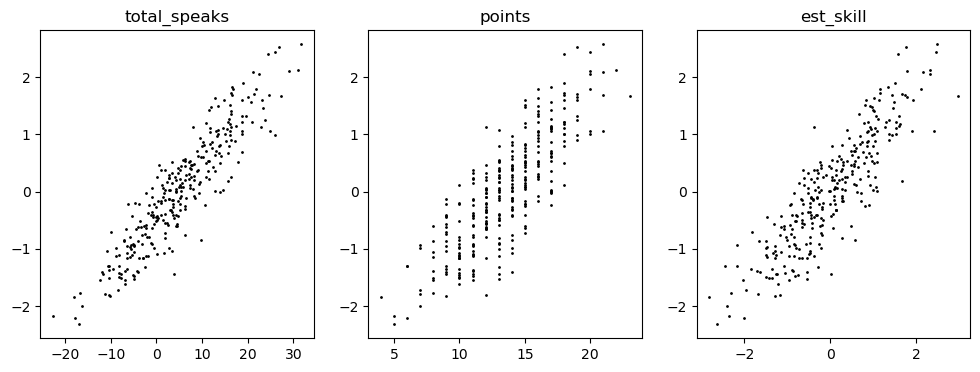

In [264]:
fig, ax = plt.subplots(ncols=3, figsize=(12, 4))
for i, col in zip(range(3), ["total_speaks", "points", "est_skill"]):
    ax[i].scatter(wudc.get_column(col), wudc.get_column("skill"), s=1, color="black")
    ax[i].set_title(col)
plt.show()